### Importamos las dependencias necesarias


Epoch 1: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 1/5
243/243 [==============================] - 367s 1s/step - loss: 0.7693 - accuracy: 0.7400 - val_loss: 73.3040 - val_accuracy: 0.3703 - lr: 0.0900

Epoch 2: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 2/5
243/243 [==============================] - 382s 2s/step - loss: 0.4338 - accuracy: 0.8067 - val_loss: 8.2403 - val_accuracy: 0.6297 - lr: 0.0900

Epoch 3: LearningRateScheduler setting learning rate to 0.09000000357627869.
Epoch 3/5
243/243 [==============================] - 381s 2s/step - loss: 0.3299 - accuracy: 0.8607 - val_loss: 0.8494 - val_accuracy: 0.6020 - lr: 0.0900

Epoch 4: LearningRateScheduler setting learning rate to 0.06300000250339508.
Epoch 4/5
243/243 [==============================] - 374s 2s/step - loss: 0.3038 - accuracy: 0.8806 - val_loss: 3.8932 - val_accuracy: 0.6297 - lr: 0.0630

Epoch 5: LearningRateScheduler setting learning rate to 0.06300000

/home/ale/Documentos/PID/genero_manos/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


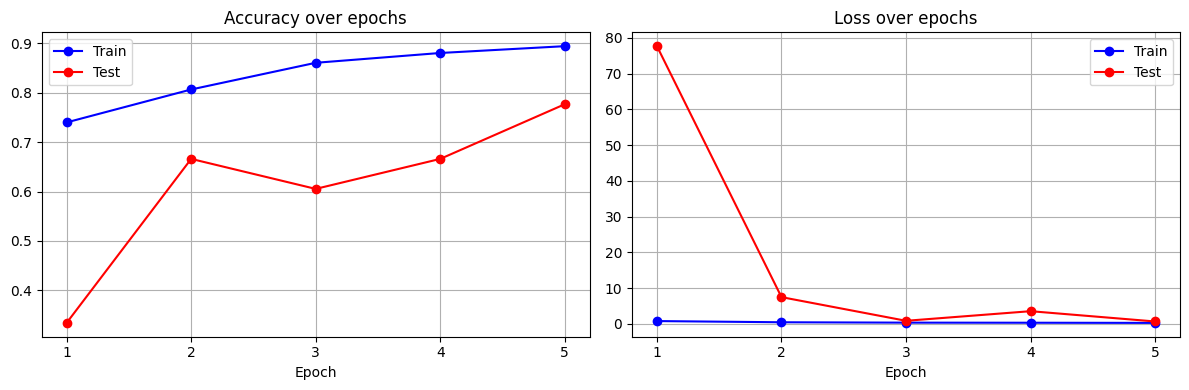

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import SGD

# ========================= Configuración =========================
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
NUM_EPOCHS  = 5

csv_path    = "/home/ale/Documentos/PID/genero_manos/dataset/HandInfo.csv"
image_root  = "/home/ale/Documentos/PID/genero_manos/dataset/image"

# ========================= Leer etiquetas =========================
df = pd.read_csv(csv_path)
df["label"] = df["gender"].map({"male":0, "female":1})
NUM_CLASSES = df["label"].nunique()

# ========================= Preprocesamiento =========================
def preprocess_raw(path_bytes: bytes) -> np.ndarray:
    """Carga la imagen, redimensiona y normaliza a [0,1]."""
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path)
    if img is None:
        return np.zeros((*IMG_SIZE,3), dtype=np.float32)
    img = cv2.resize(img, IMG_SIZE).astype(np.float32) / 255.0
    return img

def tf_preprocess(path, label):
    img = tf.numpy_function(preprocess_raw, [path], tf.float32)
    img.set_shape((*IMG_SIZE,3))
    return img, label

# ========================= Construcción de datasets =========================
def create_dataset(split: str):
    folder = os.path.join(image_root, split)
    files  = set(os.listdir(folder))
    subdf  = df[df["imageName"].isin(files)].sort_values("imageName")
    paths  = [os.path.join(folder, fn) for fn in subdf["imageName"]]
    labels = subdf["label"].values
    ds     = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds     = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset("train")
val_ds   = create_dataset("val")
test_ds  = create_dataset("test")

# ========================= ResNet‐light =========================
def residual_block(x, filters, downsample=False):
    identity = x
    stride   = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    return layers.ReLU()(x)

def build_resnet(input_shape=(224,224,3), num_classes=2):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inp)
    x   = layers.BatchNormalization()(x)
    x   = layers.ReLU()(x)
    x   = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    for _ in range(2):
        x = residual_block(x, 64)
    for i in range(3):
        x = residual_block(x, 128, downsample=(i==0))
    for i in range(4):
        x = residual_block(x, 256, downsample=(i==0))
    x   = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out)

model = build_resnet(num_classes=NUM_CLASSES)
model.compile(
    optimizer=SGD(learning_rate=0.09, momentum=0.9, decay=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# ================= Callback para test cada época =================
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_ds):
        super().__init__()
        self.test_ds = test_ds
        self.test_losses = []
        self.test_accuracies = []
    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        print(f"  → Test loss: {loss:.4f} — Test acc: {acc:.4f}")

test_cb = TestCallback(test_ds)

# ================= Scheduler de LR =====================
def lr_schedule(epoch, lr):
    if epoch == 3:
        return lr * 0.7
    return lr

lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

# ========================= Entrenamiento =========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=[lr_cb, test_cb]
)

model.save("simple_model.h5")

# ========================= Plot Train vs Test =========================
epochs     = range(1, NUM_EPOCHS+1)
train_acc  = history.history["accuracy"]
test_acc   = test_cb.test_accuracies
train_loss = history.history["loss"]
test_loss  = test_cb.test_losses

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(epochs, train_acc, marker='o', color='blue', label='Train')
ax1.plot(epochs, test_acc,  marker='o', color='red',  label='Test')
ax1.set_title("Accuracy over epochs")
ax1.set_xlabel("Epoch"); ax1.set_xticks(epochs)
ax1.legend(); ax1.grid(True)

ax2.plot(epochs, train_loss, marker='o', color='blue', label='Train')
ax2.plot(epochs, test_loss,  marker='o', color='red',  label='Test')
ax2.set_title("Loss over epochs")
ax2.set_xlabel("Epoch"); ax2.set_xticks(epochs)
ax2.legend(); ax2.grid(True)

plt.tight_layout()
plt.show()
